In [1]:
%pylab inline
from itertools import islice
import sys
import requests
import tarfile
import numpy as np
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt
import itertools as itt 
import re
from bs4 import BeautifulSoup as bs
from html import escape
from IPython.core.display import display, HTML
import json
import webdataset as wds
import glob
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


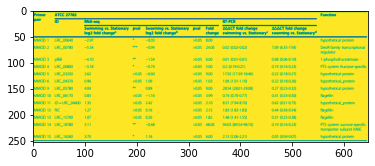

In [2]:
fnames = glob.glob("pubtabnet/pubtabnet-*[0-9]-hocr.tar")
dataset = wds.WebDataset(fnames[10]).decode("l")
it = next(islice(iter(dataset), 55, 9999999))
imshow(it["png"])

In [3]:
display(HTML(it["hocr.html"].decode("utf-8")))

In [4]:
soup = bs(it["hocr.html"])

table = soup.find("table")

In [5]:
from dataclasses import dataclass
@dataclass
class Separator:
    index: int = -1
    low: int = sys.maxsize
    high: int = -1
    def __bool__(self):
        return self.high >= self.low
    def minimize(self, q):
        if q < self.low:
            self.low = q
    def maximize(self, q):
        if q > self.high:
            self.high = q
    def size(self):
        return self.high - self.low

In [6]:
def getprops(cell):
    attrs = cell.attrs.get("title")
    if attrs is None:
        return {}
    result = {}
    for it in attrs.split(";"):
        key, value = it.split(" ", 1)
        result[key] = value
    #print(result)
    return result

In [7]:
rows = []
widths = [(100, 1)] * 100
for row in table.findAll("tr"):
    cells = []
    for cell in row.findAll("td"):
        rowspan = int(cell.attrs.get("rowspan", 1))
        colspan = int(cell.attrs.get("colspan", 1))

In [8]:
from typing import Any
@dataclass
class CellInfo:
    filler: bool = False
    rowspan: int = 1
    colspan: int = 1
    bbox: Any = None
    content: Any = None
    top: bool = True
    bottom: bool = True
    right: bool = True
    left: bool = True
    def borders_(self, other):
        self.top, self.bottom, self.left, self.right = other.top, other.bottom, other.left, other.right
        
vars(CellInfo())

{'filler': False,
 'rowspan': 1,
 'colspan': 1,
 'bbox': None,
 'content': None,
 'top': True,
 'bottom': True,
 'right': True,
 'left': True}

In [9]:
def analyze_table(table, debug=False, MAX=200):
    if debug:
        from matplotlib.patches import Rectangle
        ax = gca()
        figsize(20, 12)
    rowseps = [Separator(index=i) for i in range(MAX)]
    colseps = [Separator(index=j) for j in range(MAX)]
    grid = [[None]*MAX for i in range(MAX)]
    i = 0
    for row in table.findAll("tr"):
        cells = list(row.findAll("td"))
        j = 0
        while len(cells) > 0:
            if i > 0:
                above = grid[i-1][j]
                if above is not None:
                    if above.rowspan > 1:
                        grid[i][j] = CellInfo(rowspan=above.rowspan - 1, filler=True)
                        j += 1
                        continue
            cell, cells = cells[0], cells[1:]
            rowspan = int(cell.attrs.get("rowspan", 1))
            colspan = int(cell.attrs.get("colspan", 1))
            bbox = getprops(cell).get("bbox")
            if bbox == "None":
                bbox = None
                #print("???", cell)
            if bbox is not None:
                bbox = list(map(int, bbox.split()))
            grid[i][j] = CellInfo(rowspan=rowspan, colspan=colspan, content=cell.prettify(), bbox=bbox)
            for k in range(j+1, j+colspan):
                grid[i][k] = CellInfo(rowspan=rowspan, colspan=1, filler=True)
            if bbox is not None:
                x0, y0, x1, y1 = bbox
                rowseps[i].minimize(y0)
                colseps[j].minimize(x0)
                if rowspan > 0:
                    inserts = [(rowspan)]
                if rowspan == 1:
                    rowseps[i].maximize(y1)
                if colspan == 1:
                    colseps[j].maximize(x1)
                if debug:
                    color = "blue"
                    plot([x0, x1], [y0, y1], alpha=0.5, color="red")
                    text(x0, y1, f"{i}:{j}")
                    ax.add_patch(Rectangle((x0, y0), max(x1-x0,10), max(y1-y0, 10), color=color, alpha=0.5))
            j += colspan
        i += 1
    rowseps = list(filter(bool, rowseps))
    colseps = list(filter(bool, colseps))
    xmax, ymax = colseps[-1].high, rowseps[-1].high
    if debug:
        ax.set_xlim((0, xmax+10))
        ax.set_ylim((0, ymax+10))
        ax.invert_yaxis()
        for rowsep in rowseps:
            ax.add_patch(Rectangle((0, rowsep.low), xmax, rowsep.size(), 
                                   linewidth=4, edgecolor="#ff000080", facecolor="#ff000010"))
        for colsep in colseps:
            ax.add_patch(Rectangle((colsep.low, 0), colsep.size(), ymax, 
                                   linewidth=4, edgecolor="#00ff0080", facecolor="#00ff0010"))
    cols = list(map(vars, filter(bool, colseps)))
    rows = list(map(vars, filter(bool, rowseps)))
    grid = [[x and vars(x) for x in row if x] for row in grid]
    tablestruct = dict(cols=cols, rows=rows, grid=grid, xmax=xmax, ymax=ymax)
    json.dumps(tablestruct)
    return tablestruct

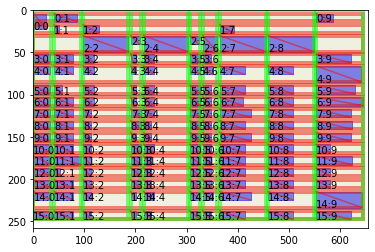

In [10]:
result = analyze_table(table, debug=True)

In [11]:
import json
json.dumps(result)[:300]

'{"cols": [{"index": 0, "low": 0, "high": 35}, {"index": 1, "low": 41, "high": 93}, {"index": 2, "low": 98, "high": 186}, {"index": 3, "low": 191, "high": 211}, {"index": 4, "low": 216, "high": 302}, {"index": 5, "low": 307, "high": 327}, {"index": 6, "low": 332, "high": 360}, {"index": 7, "low": 365'

In [12]:
url = "pubtabnet/pubtabnet-train-000000-hocr.tar"
def add_tabseg(fname, out):
    assert not os.path.exists(out)
    sink = wds.TarWriter("temp.tar")
    dataset = wds.WebDataset(url)
    for i, sample in enumerate(dataset):
        #print(sample["__key__"])
        html = sample["hocr.html"]
        soup = bs(html)
        table = soup.find("table")
        result = analyze_table(table)
        sample["table.json"] = result
        sink.write(sample)
    sink.close()
    os.rename("temp.tar", out)

In [13]:
import glob
import os
fnames = glob.glob("pubtabnet/pubtabnet-*[0-9]-hocr.tar")
for fname in fnames:
    out = re.sub("-hocr.tar", "-tabseg.tar", fname)
    if os.path.exists(out):
        print("EXISTS", out)
        continue
    print(fname, out)
    add_tabseg(fname, out)

pubtabnet/pubtabnet-test-000000-hocr.tar pubtabnet/pubtabnet-test-000000-tabseg.tar
pubtabnet/pubtabnet-train-000000-hocr.tar pubtabnet/pubtabnet-train-000000-tabseg.tar
pubtabnet/pubtabnet-train-000001-hocr.tar pubtabnet/pubtabnet-train-000001-tabseg.tar
pubtabnet/pubtabnet-train-000002-hocr.tar pubtabnet/pubtabnet-train-000002-tabseg.tar
pubtabnet/pubtabnet-train-000003-hocr.tar pubtabnet/pubtabnet-train-000003-tabseg.tar
pubtabnet/pubtabnet-train-000004-hocr.tar pubtabnet/pubtabnet-train-000004-tabseg.tar
pubtabnet/pubtabnet-train-000005-hocr.tar pubtabnet/pubtabnet-train-000005-tabseg.tar
pubtabnet/pubtabnet-train-000006-hocr.tar pubtabnet/pubtabnet-train-000006-tabseg.tar
pubtabnet/pubtabnet-train-000007-hocr.tar pubtabnet/pubtabnet-train-000007-tabseg.tar
pubtabnet/pubtabnet-train-000008-hocr.tar pubtabnet/pubtabnet-train-000008-tabseg.tar
pubtabnet/pubtabnet-train-000009-hocr.tar pubtabnet/pubtabnet-train-000009-tabseg.tar
pubtabnet/pubtabnet-train-000010-hocr.tar pubtabnet/pubt